# Adapting W2V for unsipervised glyph embedding

In [ ]:
import time
import gym
import nle

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
del gym.Wrapper.__getattr__

A wrpper that keeps track of the action history

In [ ]:
from collections import deque


class RecentHistory(gym.Wrapper):
    """The base interaction architecture is essentially a middleman, who passes
    the action to the underlying env and intercepts the resulting transition
    data. It also is allowed, but not obliged to interact with the env, while
    intercepting the observations.
    """
    def __init__(self, env, *, n_recent=0):
        super().__init__(env)
        self.recent = deque([], n_recent)

    def reset(self, seed=None):
        return self.env.reset()

    def step(self, action):
        self.recent.append(action)
        return self.env.step(action)

We hide the NLE under several layers of wrappers. From the core to the shell:
1. `ReplayToFile` saves the seeds and the takes actions into a file for later inspection and replay.
2. `NLEAtoN` maps ascii actions to opaque actions accpeted by the NLE.
3. `NLEPatches` patches tty-screens, botched by the cr-lf misconfiguration of the NLE's tty term emulator and NetHacks displays (lf only).
4. `NLEFeatures` adds extra features generated on-the-fly from the current NLE's observation. 

In [ ]:
from nle_toolbox.utils.play.wrapper import ReplayToFile, Replay
from nle_toolbox.utils.env.wrappers import NLEPatches, NLEAtoN, NLEFeatures

def gui_factory(seed=None):
    env = NLEPatches(
        ReplayToFile(
            gym.make('NetHackChallenge-v0'),
            save_on='done',
            sticky=True,
            folder='./replays',
        ),
    )

    env.seed(seed)

    return NLEAtoN(env)
    

We start with implementing a simple command evaluator.

In [ ]:
def gui_run(
    env,
    *commands
):
    pipe0 = deque([])
    obs, done = env.reset(), False
    for cmd in commands:
        pipe0.extend(cmd)
        while pipe0 and not done:
            obs, rew, done, info = env.step(pipe0.popleft())

        yield obs
        if done:
            break

A renderer

In [ ]:
import pprint as pp

from time import sleep
from nle_toolbox.utils.env.render import render as tty_render

def ipynb_render(obs, clear=True, fps=None):
    if fps is None:
        return True

    from IPython.display import clear_output
    if clear:
        clear_output(wait=True)

    print(tty_render(**obs))
    if fps > 0:
        sleep(fps)

    return True

Below is a wrapper, which handles menus (unless an interaction is required) and
fetches all consecutive messages.

In [ ]:
from nle_toolbox.bot.chassis import Chassis, ActionMasker

Let's test it in bulk.

In [ ]:
# seed = None
# seed = 12513325507677477210, 18325590921330101247  # multi
# seed = 1251332550767747710, 18325590921330101247  # single
# seed = 125133255076774710, 18325590921330101247  # single
# seed = 13765371332493407478, 12246923801353953927
# seed = 12301533412141513004, 11519511065143048485
# seed = 1632082041122464284, 11609152793318129379
seed = 12604736832047991440, 12469632217503715839  # an aspirant
# seed = 5009195464289726085, 12625175316870653325

with Chassis(RecentHistory(gui_factory(seed), n_recent=None), split=False) as env:
    for obs in gui_run(
        env,
        ';j:',         # a paragraph about a cat
#         'acy',         # break a wand "of slow" and blow up
        '\033Zbyyy,',  # cast a sleep ray at a newt and pick up its corpse
    ):
        ipynb_render(obs, clear=False)  # dump(env.env, obs[0])
        pp.pprint(
            (
                env.messages,
            )
        )

The factory for collecting random exploration rollouts

In [ ]:
# from nle_toolbox.utils import seeding

def factory(seed=None, folder=None):
    # get the base env and apply tty patches
    env = NLEPatches(gym.make('NetHackChallenge-v0'))
    ctoa = {chr(a): j for j, a in enumerate(env.unwrapped._actions)}

    # setup seed runs capabilities
    if folder is None:
        env = Replay(env, sticky=True)

    else:
        env = ReplayToFile(env, sticky=True,
                           folder=folder, save_on='done')
    env.seed(seed)

    # if not isinstance(seed, tuple):
    #     seed = seeding.generate(seed)
    # seeding.pyroot(env).set_initial_seeds(*seed, False)

    # use chassis
    env = RecentHistory(env, n_recent=32)
    return ActionMasker(Chassis(env, space=ctoa[' '], split=False))

A non-illegal random action exploration.

In [ ]:
from copy import deepcopy

def random_explore(seed=None, n_steps=1000, *, auto=False, fps=None, copy=False):
    """A non-illegal random action explorer.
    """
    ss_pol, ss_env = np.random.SeedSequence(seed).spawn(2)

    rng, j = np.random.default_rng(ss_pol), 0
    with factory(seed=ss_env) as env:
        (obs, mask), fin = env.reset(), False
        while (
            ipynb_render(obs, clear=True, fps=fps)
            and not (fin or j >= n_steps)
        ):
            # though nle reuses buffers, we do not deep copy them
            #  delegating this to the downstream user instead
            yield deepcopy(obs) if copy else obs

            # sample from non-forbidden actions
            # XXX whelp... tilde uint8 flips the sign bit and is not the logical not
            act = rng.choice(*np.logical_not(mask).nonzero())
            (obs, mask), rew, fin, info = env.step(act)
            j += 1

            if fin and auto:
                ipynb_render(obs, clear=True, fps=fps)
                (obs, mask), fin = env.reset(), False    

Set up the glyph-to-vec embedding model

In [ ]:
import torch
import torch.nn.functional as F

from collections import OrderedDict

from torch import nn
from torch.nn.utils.weight_norm import weight_norm

from nle.nethack import MAX_GLYPH, DUNGEON_SHAPE

from nle_toolbox.utils.env.defs import glyphlut
from nle_toolbox.utils.env.defs import MAX_ENTITY, glyph_group

from nle_toolbox.bot.model.glyph import GlyphEmbedding


embedding = GlyphEmbedding(embedding_dim=128)
g2v = nn.Sequential(OrderedDict([
    ('inp', embedding),
    ('out', weight_norm(
        # XXX are we sure we need this weight reparam here?
        #  \frac{g_j}{\|w_j\|} w_j, j=0..d for m -->> d linear layer
        nn.Linear(128, MAX_ENTITY + 1, bias=False)
    )),
]))

optim = torch.optim.Adam(
    g2v.parameters(),
    lr=1e-3,
)

n_border = 1

### w2v

Let's repurpose the word-to-vec skip-gram model to train good initial glyph embeddings.

$$
p(w\mid c)
    \propto \exp\{\theta_w^\top \phi_c\}
    \,,$$
$\phi_v, \theta_v \in \mathbb{R}^d$.

Consider the context graph $G = (V, E)$. Skip-gram W2V embedding models the probability of
a context $G_c$ of a given token $c$ with
$$
p(G_c)
    = \pi(c) p(G_c \mid c)
    = \pi(c) \prod_{w \in G_c} p(w \mid c)
    \,, $$
where $
    G_v := \{w \in G\colon vw in E\}
$ is the collection of the $E$-neighbours of $v$ and $w \in G$ stands for iterating
over tokens in $V$ with $w$.

Assuming independent contexts (**why?**), skip-gram W2V maximizes the following log-likelihood:
$$
\mathcal{L}
    = \frac1{\lvert G \rvert} \sum_{c \in G} \log p(G_c)
    = \frac1{\lvert G \rvert} \sum_{c \in G} \biggl(
        \log \pi(c) + \sum_{w \in G_c} \log p(w\mid c)
    \biggr)
    \,. $$

Let's notice that $G$ is an undirected graph, which implies that
$$
\sum_{c\in G} \sum_{w \in G_c}
        = \sum_{uw \in E}
        = \sum_{w \in G} \sum_{c \in G_w}
    \,. $$
Hence,
$$
\mathcal{L}
    = \frac1{\lvert G \rvert} \sum_{w \in G} \biggl(
        \log \pi(w) + \sum_{c \in G_w} \log p(w\mid c)
    \biggr)
    \,. $$

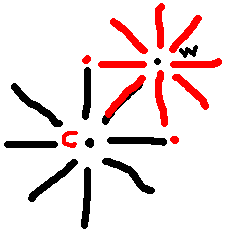

Ignoring the prior glyph probabilities (**why?**) and randomizing over the contexts,
the final loss to be minimized is
$$
\mathcal{L}
    = \mathbb{E}_G \mathbb{E}_{w\sim G}
        \sum_{c \in G_w} \log p(w\mid c)
    \,, $$
which means that it is possible to sample contexts $G_w$ instead of full 2d meshes $G$.

The following online batch prefetcher logic was copied from elsewhere.

In [ ]:
import tqdm
from torch.utils.data._utils.collate import default_collate

from nle_toolbox.utils.fold import pyt_fold2d

it = random_explore(
    seed=None,
    n_steps=float('inf'),
    auto=True,
    copy=False,
    fps=0.01,
)
losses = []

# the stream prefetch buffer size, the batch size, and
#  the overall number of batches
n_buffer_size, n_batch_size, n_batches = 256, 1, 500*8
prefetch, buffer = [], []
# XXX we can actually fetch the neighbouring context into the buffer

# bordering array (MAX_GLYPH <<-->> MAX_ENTITY)
rows, cols = DUNGEON_SHAPE
bordered = np.full(
    (n_border + rows + n_border, n_border + cols + n_border),
    MAX_GLYPH, dtype=np.int16)
stage = bordered[n_border:-n_border, n_border:-n_border]

# prng for prefetch -->> batch eviction
rng = np.random.default_rng()

# the total number of step in the env (+1 for collation step)
n_total = n_buffer_size + (n_batch_size + 1) * n_batches
with tqdm.tqdm(range(n_total), ncols=80, disable=True) as bar:
    for j in bar:
        # (collect) fetch the next obs
        obs = next(it)

        # (collect) we reuse the buffer
        np.copyto(stage, obs['glyphs'])
        item = bordered.copy()

        # (collect) add a sample to the prefetch buffer
        if len(prefetch) < n_buffer_size:
            prefetch.append(item)
            continue

        # (collect) if prefetch is full, randomly evict into the batch buffer
        elif len(buffer) < n_batch_size:
            ix = rng.integers(len(prefetch))
            buffer.append(prefetch[ix])
            prefetch[ix] = item
            continue

        # XXX reached every `n_batch_size`-th iteration after the prefetch
        #  buffer has been saturated
        pass

        # (collect) collate a batch and flush
        batch = default_collate(buffer)
        buffer.clear()

        # (g2v) fwd through the embedding model
        # XXX \log p(w \mid c) conditional prob of w given c
        raw = g2v(batch).permute(0, 3, 1, 2).clone()
        logprob = F.log_softmax(raw, dim=1)

        # (g2v) ignore the artificial borders
        _, entity = embedding.lookup(batch[..., n_border:-n_border, n_border:-n_border])
        context = pyt_fold2d(raw, k=n_border, n_leading=-2)
        c_raw = raw[..., n_border:-n_border, n_border:-n_border]

        # (g2v) compute the skip-gram embedding loss
        # XXX full[:, x, y, i, j] = \log p((x, y) \mid (i, j))
        #     cent[:, x, y] = \log p((x, y) \mid (x, y))
        # XXX .cross_entropy does its own `log_softmax`
        target = entity.reshape(*entity.shape, 1, 1).expand(-1, -1, -1, *context.shape[-2:])
        full = F.cross_entropy(context, target, reduction='none')
        cent = F.cross_entropy(c_raw, entity, reduction='none')

        loss = full.sum((-1, -2)).mean() - cent.mean()

        # (train) zero-grad backward and step blah blah yada yada
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(float(loss))

        bar.set_postfix_str(f'{float(loss):.2e}')

<br>